# Test the GANs using PhysEngine

In [46]:
import os
import sys
dirname = os.path.dirname(os.path.realpath('__file__'))
print(dirname)

sys.path.append(dirname + "/../PN_representability/GANs/")

from GAN_Model import Generator
import pandas as pd
import numpy as np
import scipy.linalg
import scipy.optimize
from numpy.core.umath_tests import inner1d
import torch
from scipy.optimize import Bounds,SR1
import matplotlib
import matplotlib.pyplot as plt

sys.path.append(dirname + "/../QuantumReinforce/")
from GAN_Model import Generator
from Physics_Engine import Physics_Engine as PE

/home/romain/Documents/EPFL/C3MP/DRLDMET/DensityMatrix


In [47]:

coding_dim = 50
nb_data = 30000
working_dim = 2211
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Declare the generator
generator = Generator(coding_dim, working_dim)
gan_weights = 'generator_weights_'+str(coding_dim)+'_'+str(nb_data)+'_episodes_50.pth'
generator.load_state_dict(torch.load(gan_weights))


# Test the generator

In [32]:

with torch.no_grad():
    print(generator.forward(torch.randn(coding_dim).to(device)))


tensor([ 0.3675, -0.0451,  0.2614,  ..., -0.0178, -0.0294,  0.2912], device='cuda:0')


# Get the 2RDM matrix

In [33]:
def get_matrix_index(k,l):
    '''
    The 2-RDM tensor is stored as a matrix.from 2 coefficients we can get the 1 of the matrix
    :param a: coef a
    :param b: coef b
    :return: index in the matrix
    '''
    # makre sure that the order is correct
    s=12
    [k,l]=np.sort([l,k])
    return int(l - k + (2*s- k - 1) * k / 2-1)

def double2single(m_2rdm):
    '''
    Get the 1-RDM from a 2-RDM
    :param m_2rdm: matrix of the 2-RDM
    :return: 1-RDM
    '''
    s=12
    n=6
    # initialize the matrix
    rho = np.zeros([s,s])
    # populate the matrix by looping over the coefficients a and b
    for alpha in np.arange(s,dtype=int):
        for beta in np.arange(s,dtype=int):
            # elements to trace out
            for nu in np.arange(s,dtype=int):
                # 0 contribution if nu is alpha or beta
                if nu != alpha and nu!=beta:
                    # take care of the sign
                    sgn = 1
                    if nu < alpha:
                        sgn*=-1
                    if nu < beta:
                        sgn*=-1
                    rho[alpha,beta]+=sgn*m_2rdm[get_matrix_index(min(alpha,nu),max(alpha,nu)),get_matrix_index(min(beta,nu),max(beta,nu))]

    return rho*2/(n-1)

def get_2rdm(p_gan):
    '''
    Use the generator to get a 2-RDM from the parameters
    :param p_gan: parameters in the coding space
    :return: 2rdm
    '''
    # get the coefficients of the matrix L
    s=12
    n=6
    p_gan_tensor= torch.from_numpy(p_gan).float()
    p_gan_tensor_cuda = p_gan_tensor.to(device)    
    with torch.no_grad():
        L=generator.forward(p_gan_tensor_cuda).squeeze()
    # Rebuild L cholevski
    dim = int(s*(s-1)/2)
    L_chol = np.zeros([dim,dim])
    c = 0
    for j in np.arange(dim):
        for i in np.arange(dim):
            if j >= i:
                L_chol[i,j] = L[c]
                c +=1
    rho = np.matmul(L_chol.T,L_chol)
    rho_1 = double2single(rho)
    rho*=n/np.trace(rho_1)
    return rho


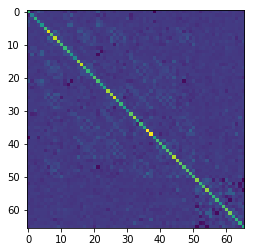

0.0


In [34]:
p_gan = np.random.normal(0,1,[1,coding_dim])
rdm2=get_2rdm(p_gan)
plt.imshow(rdm2)
plt.show()
print(np.max(np.abs(rdm2-rdm2.T)))


def get_rho_from_matrix(rho,i,j,k,l):
    if (i== j or k==l):
        rho_ijkl=0
    else:
        signe=1
        if(i>j):
            signe=signe*-1
        if(k>l):
            signe=signe*-1
        x=get_matrix_index(min(i,j),max(i,j))
        y=get_matrix_index(min(k,l),max(k,l))
        rho_ijkl=signe*rho[x,y]
    return rho_ijkl


def get_rho_energy(rho,u):
    t=1
    rho1=double2single(rho)
    Ecin=0
    list_bin = [[0,1],[1,3],[3,5],[5,4],[4,2],[2,0]]
    for bin in list_bin:
        i = bin[0]
        j= bin[1]
        Ecin = Ecin -t* (rho1[i,j]+rho1[j,i]+rho1[i+6,j+6]+rho1[ j+6,i+6])
    Epot=0
    for i in range(6):
        Epot = Epot + 2*u * get_rho_from_matrix(rho,i,i+6,i,i+6)
    
    return Ecin+Epot

def e_var(p_gan,u):
    rdm2=get_2rdm(p_gan)
    return get_rho_energy(rdm2,u)

In [35]:
p_gan = np.random.uniform(0,1,coding_dim)
print(p_gan)
p_gan_tensor= torch.from_numpy(p_gan).float()
p_gan_tensor_cuda = p_gan_tensor.to(device)    
print(p_gan_tensor_cuda)
with torch.no_grad():
    L=generator.forward(p_gan_tensor_cuda).squeeze()
print(L)



[0.5388759  0.11963957 0.48187991 0.53500008 0.18062144 0.1346506
 0.49954268 0.29707966 0.22258251 0.83171625 0.02408936 0.52038044
 0.56192191 0.63799524 0.39880532 0.02054816 0.93409843 0.20439256
 0.31086447 0.71031198 0.63479215 0.83123334 0.60925349 0.21536205
 0.85735583 0.16934897 0.76804409 0.07378736 0.26324319 0.1559328
 0.02336419 0.93073565 0.74257044 0.36265877 0.78956542 0.48867721
 0.23937531 0.05946794 0.61997439 0.10586261 0.92819687 0.99773015
 0.11871052 0.63248003 0.64888505 0.94968691 0.5858895  0.67688362
 0.26837068 0.79812612]
tensor([0.5389, 0.1196, 0.4819, 0.5350, 0.1806, 0.1347, 0.4995, 0.2971, 0.2226,
        0.8317, 0.0241, 0.5204, 0.5619, 0.6380, 0.3988, 0.0205, 0.9341, 0.2044,
        0.3109, 0.7103, 0.6348, 0.8312, 0.6093, 0.2154, 0.8574, 0.1693, 0.7680,
        0.0738, 0.2632, 0.1559, 0.0234, 0.9307, 0.7426, 0.3627, 0.7896, 0.4887,
        0.2394, 0.0595, 0.6200, 0.1059, 0.9282, 0.9977, 0.1187, 0.6325, 0.6489,
        0.9497, 0.5859, 0.6769, 0.2684, 0.

In [84]:

import torch
from torch.distributions import uniform

distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([1.0]))
a=distribution.sample(torch.Size([coding_dim])).squeeze().to(device)

with torch.no_grad():
    print(generator.forward(a))


tensor([-49.2130, -48.1160,  48.5478,  ..., -48.1149,  46.1934,  45.8067],
       device='cuda:0')


In [85]:
u=0
p_gan = np.random.uniform(0,1,coding_dim)
print(p_gan)

print("energy before optimisation")
print(e_var(p_gan,u))
bounds = Bounds(np.zeros([len(p_gan)]),np.ones([len(p_gan)])) # the parameters are between 0 and 1 by definition
f = lambda p_gan : e_var(p_gan,u)
# we save the result
result = scipy.optimize.minimize(f,p_gan,bounds=bounds,options={"maxiter":1000,"eps":1/75.0,"gtol":0,"ftol":0.01,"pgtol":0})
#result = scipy.optimize.minimize(f,p_gan,options={"maxiter":1000,"eps":1/50.0,"gtol":0,"ftol":0})
print("energy after")
print(result)


[0.48469242 0.32546401 0.50629505 0.32698072 0.61433379 0.31294635
 0.59909076 0.90868673 0.33268694 0.12083656 0.34338021 0.41882256
 0.76299904 0.09655787 0.07372198 0.30781433 0.14745928 0.28608014
 0.47298228 0.11403195 0.84717231 0.08951951 0.95467401 0.58106465
 0.63340775 0.22651927 0.62050944 0.85976227 0.57426342 0.42205103
 0.61687136 0.24991493 0.35507529 0.39907674 0.73157124 0.4113314
 0.78750849 0.91100334 0.78349187 0.81602172 0.78779106 0.42615999
 0.8269341  0.89930089 0.89365207 0.93619455 0.84977085 0.49104914
 0.47381789 0.058044  ]
energy before optimisation
-0.014963142426209532
energy after
      fun: -0.014963174857810818
 hess_inv: <50x50 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.69421745e-05,  1.77646129e-05,  2.12608208e-05, -1.27123824e-05,
        1.28741831e-05, -3.95151087e-06, -1.41426807e-05,  2.05096410e-05,
       -3.71139178e-05,  1.18876315e-05,  3.10286922e-05, -3.01523266e-05,
       -1.60768220e-05,  3.96893613e-06,  2.90689799

/home/romain/.conda/envs/DRL/lib/python3.6/site-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: pgtol
  # Remove the CWD from sys.path while we load stuff.


# get the Hamiltonian

In [115]:
U=1
pe = PE(4, 2, 0.5,[0,0],U)
print(pe.nb_electrons)
print(pe.lattice)

6
[[0 1 2 0]
 [3 0 0 4]
 [0 5 6 0]
 [0 0 0 0]]


In [82]:
H=pe.get_H()
print(H)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [44]:

v,w = scipy.linalg.eigh(H)

In [46]:
psi = w[:,0]
a=pd.DataFrame(psi)
a.to_csv("gs_1.csv",index=False,header=False)
print(v[0])

-6.601158293375114


In [47]:
r = pd.read_csv("r1_1.csv",header=None)
print(np.shape(r.values))


(66, 66)


In [51]:
def get_rho_cin(rho):
    t=1
    Ecin=0
    list_bin = [[0,1],[1,3],[3,5],[5,4],[4,2],[2,0]]
    for bin in list_bin:
        i = bin[0]
        j= bin[1]
        Ecin = Ecin -t* (rho[i,j]+rho[j,i]+rho[i+6,j+6]+rho[ j+6,i+6])

    return Ecin
get_rho_energy(r.values,1)

-6.601080000000001